# 過学習と汎化


## Out-of-Sampleデータに対する予測能力

重回帰モデルでのモデル選択・説明変数の選択を解説します。重回帰モデルは
説明変数の数を増やせば増やすほど、説明変数のバラツキをうまく組み合わせて
目的変数にフィットさせることが出来ます。サンプルサイズが$n$なら、
$n-1$個の説明変数をもってくれば、切片と合わせて$n$個のパラメータと
なり、$n$個のパラメータをうまく選べば$n$個の目的変数に一致させらるのです。

しかし、このようなモデルには意味がありません。モデルはデータにフィットさせるのが
目的ではなく、モデルのフィットに用いたデータ（In sample データと呼びます）とは異なる、こらから得られるデータ（未知のデータ, Out of sample データと呼びます）
に対して、目的変数の値を予測することを目的として構築します。この未知のデータに対する予測能力のことを汎化性能・汎化能力と呼びます。


## モデルの柔軟性と過学習


一般に、説明変数を増やすなどモデルを複雑にすればするほど、モデルは
柔軟になり、データの記述力が増します。柔軟で記述力の高いモデルは
複雑なメカニズムを記述できる高い能力を持ちます。特に、データが膨大にある場合、複雑な
モデルをデータにフィットさせることができれば、複雑な現象に対してもうまく
予測することが出来るます。

一方、データが少ない場合、複雑なモデルは危険です。少ないデータだと完璧にフィットさせることが出来ます。すると、データが持つノイズにモデルがフィットしてしまうことになります。これを過学習・オーバーフィッティングと呼びます。過学習を防ぐには、柔軟性があまりない、記述力の低いモデルのほうがよいです。

例えば、ある説明変数は目的変数には関係ないとします。しかし、
その説明変数の変化を利用して、目的変数とモデルのフィットを
改善できます。しかし、本来、その変数は目的変数とは関係ないので、
新しいデータに対して目的変数を予測するとき、目的変数とは
無関係な数値＝ノイズとなるのです。無関係な目的変数を
増やせば増やすほど、ノイズが累積し、重回帰モデルの場合、
結果としてモデルの予測値と目的変数の相関係数が負になることもあります。





## バイアスとバリアンスのトレードオフ

このように、説明変数が多い柔軟なモデルは、データが十分多い場合には
データの構造を記述する高い能力が持ちます。一方、データが少ない場合は
ノイズにフィットしてモデルの予測能力を低下させます。
データが無限に与えられたとき、真のデータ構造にフィットさせられない
度合いを「バイアス」と呼びます。説明変数の多い柔軟なモデルは
「バイアスが小さく」、説明変数の少ない柔軟性に欠けるモデルは「バイアスが
大きい」です。

一方、有限でのデータでは、データのノイズを完全には除去できず、
そのため、データごとにフィットしたモデルが異なります。データごとに
フィットしたモデルが異なる度合いを「バリアンス」と呼びます。
バリアンスはデータの量とモデルの柔軟性で決まります。データ量が少なくモデルが柔軟
な場合、バリアンスは大きく、モデルが柔軟でない場合、バリアンスは小さいです。

モデルの未知のデータに対する予測能力は「バイアス」と「バリアンス」の和
で決まります。

$$
\mbox{モデルのOut of Sampleデータに対する予測能力}=-(\mbox{バイアス}+\mbox{バリアンス})
$$
ここで右辺の和の前にーとしていますが、バイアスが大きければ大きいほど、
バリアンスが大きければ大きいほど予測能力が低下することを意味しています。

そして、有限のデータでは、「バイアス」と「バリアンス」はトレードオフの
関係にあります。

$$
\mbox{バイアス}\stackrel{トレードオフ}{\leftrightarrow} \mbox{バリアンス}
$$

モデルの柔軟度を増せば、バイアスは小さくなりますが、バリアンスは大きくなり、
逆に、モデルを単純にすれば、バリアンスは小さくなりますが、バイアスは大きくなります。モデルの選択は、このトレードオフ関係のバランスをとって、
予測能力が最大になるモデルを選ぶことです。


では、重回帰モデルで説明変数をどのように選択すればいいのでしょうか。ここでは、
多項式回帰モデルを例に、交差検証法により正しいモデルを導く方法を解説します。










### 分析の準備

In [313]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
# 統計モデルを推定するライブラリ(ワーニングが出ることもあります)
import statsmodels.formula.api as smf
import statsmodels.api as sm
# 機械学習法を適用するためのライブラリ
from sklearn import linear_model
from sklearn.model_selection import train_test_split
# グラフをjupyter Notebook内に表示させるための指定
%matplotlib inline

---

# 多項式回帰とモデル選択

真の確率モデル$q(x)$を考える。目的変数$y$は$q(x)$を中心に$\pm \sigma$でバラつくとします。

$$
y\sim N(q(x),\sigma^2)
$$

この確率モデルからサンプルサイズ$n$のデータ$D:\{(x_i,y_i)\}_{i=1,\cdots,n}$を取得したとする。


データ$(x_i,y_i),i=1,\cdots,n$から$q(x)$を知ることは可能なのか？

真のモデルが1次式の場合:

$$
q(x)=5x+20,x\in[-3,3],\sigma=5
$$

の場合に、多項式モデルでフィットしてみます。

$$
f(x)=b_0+b_1 \cdot x+b_2\cdot x^2+\cdots +b_6 \cdot x^6
$$

$$
y\sim N(f(x),\sigma^2)
$$




$n=7$のデータ$D=\{(x_i,y_i)\}_{i=1,\cdots,7}=\{(-3,y_1),(-2,y_2),(-1,y_3),(0,y_4),(1,y_5),(2,y_6),(3,y_7)\}$を作成してみる

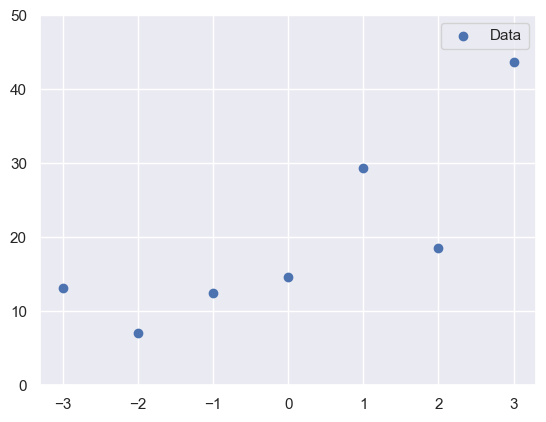

In [314]:
#乱数のシードを1に設定
np.random.seed(1)
#ノイズの標準偏差
sigma=5
#サンプルサイズ
n=7
#説明変数
x=np.linspace(-3,3,n)
#真のモデル
def q(x):
  return 20+5*x
#目的変数の生成
y=stats.norm.rvs(loc=q(x),scale=sigma,size=len(q(x)))
#データフレーム化
df=pd.DataFrame({"x":x,"y":y})
#散布図のプロット
plt.scatter(df.x,df.y,label="Data")
#y軸の範囲を指定
plt.ylim([0,50])
#凡例を表示
plt.legend()
#プロット
plt.show()

### 問題1

$x=\{-3,-2,-1,0,1,2,3,\}$に対して$q(x)$を計算し、$q_x$に代入せよ。

$q_x$を表示せよ。



In [315]:
#1 
# x=-3,-2,-1,0,1,2,3に対してq(x)を計算し,q_xに代入・表示
q_x=q(df.x)
print(q_x)

0     5.0
1    10.0
2    15.0
3    20.0
4    25.0
5    30.0
6    35.0
Name: x, dtype: float64


真のモデルの$q(x)$を散布図にプロットしてみます。

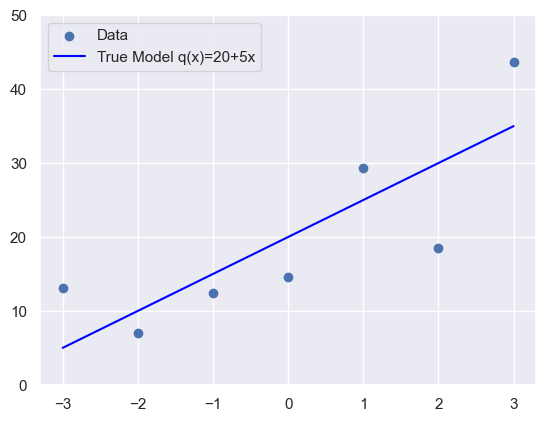

In [316]:
#真のモデルの q(x) を散布図にプロット
#散布図のプロット
plt.scatter(df.x,df.y,label="Data")
#真のモデルq(x)のプロット
plt.plot(df.x,q(df.x),color="blue",label="True Model q(x)=20+5x")
#y軸の範囲を指定
plt.ylim([0,50])
#凡例を表示
plt.legend()
#プロット
plt.show()

単回帰してみましょう。

$$
f(x)=\beta_0+\beta_1 x
$$

と仮定し、データにフィットするように$\beta_0,\beta_1$を決めます。
フィットした値を$\hat{\beta}_0,\hat{\beta}_1$と書くことにします。





### 問題2

$y$を$x$で単回帰し、回帰係数を表示せよ。

In [317]:
#2 y をxで単回帰し、回帰係数を表示
#説明変数1の単回帰
lm_v1= smf.ols("y ~ x", df).fit()
#切片と回帰係数
print(lm_v1.params)

Intercept    19.800092
x             4.709895
dtype: float64


$\hat{\beta}_0=19.8,\hat{\beta}_1=4.71$となりました。真の値$\beta_0=20,\beta_1=5$と大体一致しています。

フィットした値を$\hat{\beta}_0,\hat{\beta}_1$を用いて$y_i$に
あてはめた値を$\hat{y}_i$と書くことにします。

$$
\mbox{あてはめ値:fitted value}:\hat{y}_i=\hat{\beta}_0+\hat{\beta}_1 x_i
$$

注意：「あてはめ値(fitted value)」を「予測値(predicted value)」と書くテキストが多いのです。が、誤解を招くので紛らわしいので、以下では「予測値」はモデルの推定に用いていない、未知のデータ(Out-of-Sample Data)に対してモデルで予測した値を指すことにします。

回帰モデルの推定に用いたデータでモデルを推定し、推定したモデルで推定に用いたデータで目的変数を計算したものは、目的変数にモデルをフィットさせた結果なので、「あてはめ値」でしかありません。この違いをこれから確認していきます。


単回帰モデルのあてはめ値を変数(fit_v1)に代入し、推定した回帰直線をプロットします。

当てはめ値を計算する場合、predict()メソッドを使います。ただし、データはモデルのフィットに用いたものと同じです。


### 問題3

当てはめ値を計算し、fit_v1にインプットし、最後の成分のみを表示せよ。

In [318]:
#3　当てはめ値を計算し、fitted_value_v1にインプットし、最後の成分のみを表示
fit_v1=lm_v1.predict(df)
print(fit_v1.iloc[6])

33.92977841774643


データの散布図に真のモデル$q(x)$と推定した$\hat{\beta}_0+\hat{\beta}_1x$をプロットします。

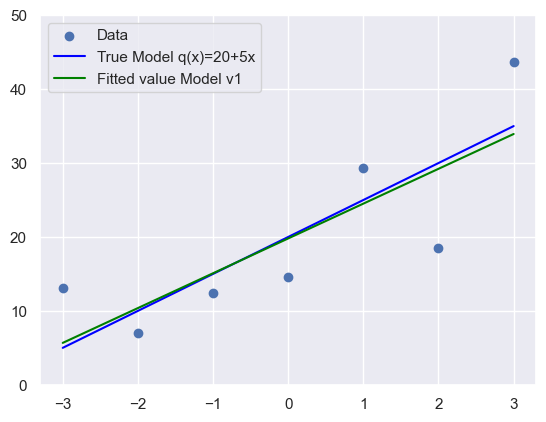

In [319]:
#データの散布図
plt.scatter(df.x,df.y,label="Data")
#真のモデル式のプロット
plt.plot(df.x,q(df.x),color="blue",label="True Model q(x)=20+5x")
#予測値の計算
fit_v1=lm_v1.predict(df)
#予測値の折れ線グラフのプロット
plt.plot(df.x,fit_v1,color="green",label="Fitted value Model v1")
plt.ylim([0,50])
#凡例の表示
plt.legend()
#グラフの表示
plt.show()

サンプルサイズは7と小さいですが、真のモデルが1次式なので、単回帰（1次式）モデルを用いると、真のモデルに近いモデルを推定することが出来ています。

残差、全変動和、残差変動和、あてはめ値の変動和、決定係数、修正決定係数を計算します。

$$
\mbox{残差,residuals}:\epsilon_i=y_i-\hat{y}_i
$$

$$
\mbox{目的変数の平方和}:\sum_{i=1}^{n}(y_i-\overline{y})^2
$$

$$
\mbox{残差平方和}:\sum_{i=1}^{n}\epsilon_i^2
$$

$$
\mbox{あてはめ値の平方和}:\sum_{i=1}^{n}(\hat{y}_i-\overline{y})^2
$$


$$
\mbox{決定係数}:R^2=1-\frac{\mbox{残差平方和}}{\mbox{目的変数の平方和}}
$$

$$
\mbox{モデルの自由度(degree of freedom)}:DF(Model)=\mbox{回帰係数の個数}
$$

$$
\mbox{残差の自由度}:DF(Residuals)=\mbox{サンプルサイズ}n-\mbox{モデルの自由度}-1
$$

$$
\mbox{修正決定係数}:R^2=1-\frac{\mbox{残差平方和}/\mbox{DF(Residuals)}}{\mbox{目的変数の平方和}/(n-1)}
$$



### 問題4:上記定義に従って決定係数、修正決定係数を計算し表示せよ。

In [320]:
#4 上記定義に従って決定係数、修正決定係数を計算し表示
#残差の計算
fit_error_v1=df.y-fit_v1
#目的変数の平方和
S_y=np.sum((y-np.mean(y))**2)
#残差平方和
S_fit_error_v1=np.sum(fit_error_v1**2)
#当てはめ値の平方和
S_fit_v1=np.sum((fit_v1-np.mean(fit_v1))**2)
#決定係数
Rsquared_v1=S_fit_v1/S_y
#修正決定係数
adjRsquared_v1=1-(S_fit_error_v1/(n-2))/(S_y/(n-1))
#結果の表示
print(Rsquared_v1,adjRsquared_v1)

0.6491546464931447 0.578985575791773


回帰分析の結果を確認します。オブジェクト変数で決定係数を確認します。

### 問題5

単回帰分析の結果のオブジェクト("OLSResults"オブジェクト)のインスタンス変数rsquared,rsquared_adjをタプル型で表示せよ。

In [321]:
#5 単回帰分析の結果のオブジェクト("OLSResults"オブジェクト)のrsquared,rsquared_adjをタプル型で表示
print(lm_v1.rsquared,lm_v1.rsquared_adj)

0.6491546464931442 0.5789855757917731


推定した回帰係数で計算した決定係数、修正決定係数が一致しているはずです。

決定係数が0.65ということは、目的変数の変動の約2/3を単回帰モデルで記述したことになります。




## モデルの評価指標

決定係数とモデルのパラメータ数で修正した修正決定係数をモデルの評価指標として紹介しました。

$$
R^2=\frac{当てはめ値の平方和}{目的変数の平方和}=1-\frac{残差の平方和}{目的変数の平方和}
$$

一方、決定係数とは別に、残差の平方の平均やその平方根もよく使われます。
前者を、Mean Squared Error (MSE)、後者をRoot Mean Squared Errorと呼びます。


$$
MSE(\mbox{残差の平方の平均})=\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2
$$


$$
RMSE(\mbox{残差の平方の平均値の平方根})=\sqrt{\mbox{MSE}}
$$

また、二乗せずに絶対値の平均値(Mean Absolute Error,MAE,平均絶対値誤差)も使われます。






## 多項式回帰

では、2次式でデータにフィットさせてみましょう。

$$
y=\beta_0+\beta_1 \cdot x+\beta_2 \cdot x^2
$$


データフレームdfに$x^2$を要素とする"x2"列を追加します。

In [322]:
#二次の項を説明変数に追加
df["x2"]=x*x

### 問題6

$y$を$x$の2次式で回帰し、回帰係数を表示せよ。

In [323]:
#6 y をxの2次式で回帰し、回帰係数を表示
#2次の多項式回帰
lm_v2= smf.ols("y ~ x+x2", df).fit()
#切片と回帰係数をプロットします。
print(lm_v2.params)

Intercept    15.008199
x             4.709895
x2            1.197973
dtype: float64


### 問題7

当てはめ値を計算し、fit_v2にインプットし、最後の成分のみを表示せよ。

In [324]:
#7　当てはめ値を計算し、fitted_value_v1にインプットし、最後の成分のみを表示
fit_v2=lm_v2.predict(df)
print(fit_v2.iloc[6])

39.91964523228202


データの散布図に真のモデル$q(x)$と推定した$\hat{\beta}_0+\hat{\beta}_1x+\hat{\beta}_2 x^2$をプロットします。

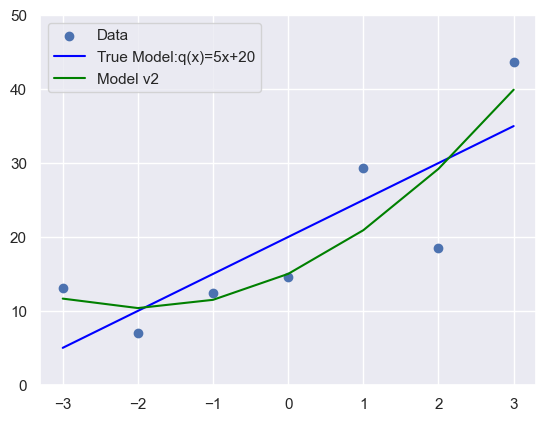

In [325]:
#データの散布図
plt.scatter(df.x,df.y,label="Data")
#真のモデル式q(x)のプロット
plt.plot(x,q(df.x),color="blue",label="True Model:q(x)=5x+20")
#予測値の計算
fit_v2=lm_v2.predict()
#予測値の折れ線グラフのプロット
plt.plot(x,fit_v2,color="green",label="Model v2")
plt.ylim([0,50])
#凡例の表示
plt.legend()
#グラフの表示
plt.show()

フィットして得られたモデルは概ね次の式です。

$$
f(x)=15+4.7x+1.2x^2
$$

真のモデル$q(x)=5x+20$よりもデータにフィットしています。

これが過学習です。真のモデルよりも2次の項の分だけモデルが柔軟になっています。
その柔軟性を活かして、データに含まれるノイズにフィットしているのです。

もちろん、未知のデータは$q(x)=5x+20$で生成されます。すると、$1.2 x^2$の
項は誤差となります。

データが無限に多い場合、2次の項の係数はゼロとなりますが、
データが有限の場合、ゼロとなることはありません。



### 問題8 :定義式に従って2次式モデルの決定係数、修正決定係数を計算し表示せよ。

In [326]:
#8 定義式に従って2次式モデルの決定係数、修正決定係数を計算し表示
#残差の計算
fit_error_v2=y-fit_v2
#残差変動和
S_fit_error_v2=np.sum(fit_error_v2**2)
#予測値の変動和
S_fit_v2=np.sum((fit_v2-np.mean(y))**2)
#決定係数
R_sq_v2=S_fit_v2/S_y
#修正決定係数
adj_R_sq_v2=1-(S_fit_error_v2/(n-3))/(S_y/(n-1))
#結果の表示
print(R_sq_v2,adj_R_sq_v2)

0.7751461419601733 0.6627192129402599


回帰分析の結果を確認します。オブジェクト変数で決定係数を確認します。

### 問題9

単回帰分析の結果のオブジェクト("OLSResults"オブジェクト)のインスタンス変数rsquared,rsquared_adjをタプル型で表示せよ。

In [327]:
#9 単回帰分析の結果のオブジェクト("OLSResults"オブジェクト)のrsquared,rsquared_adjをタプル型で表示
print(lm_v2.rsquared,lm_v2.rsquared_adj)

0.7751461419601733 0.6627192129402599


1次式モデルに比べて決定係数は大きくなるのは当然としても、パラメータを増やしたことを加味した修正決定係数も大きくなっています。

修正決定係数の大きなモデルを採用することがありますが、その結果、間違った
モデルを採用することになるわけです。

## 多項式モデルの回帰（３次以上）


では、3次式モデル、4次式モデル、5次式モデル、6次式モデルをフィットしてみます。

まず、データフレームdfに3次、4次、5次、6次の列を追加します。

In [328]:
#n=7なので6次式で完璧にフィットできる
#3,4,5,6次の項を説明変数に追加
df["x3"]=x**3
df["x4"]=x**4
df["x5"]=x**5
df["x6"]=x**6
df.head()

,x,y,x2,x3,x4,x5,x6
0,-3.0,13.121727,9.0,-27.0,81.0,-243.0,729.0
1,-2.0,6.941218,4.0,-8.0,16.0,-32.0,64.0
2,-1.0,12.359141,1.0,-1.0,1.0,-1.0,1.0
3,0.0,14.635157,0.0,0.0,0.0,0.0,0.0
4,1.0,29.327038,1.0,1.0,1.0,1.0,1.0


### 問題10

3次式モデル、4次式モデル、5次式モデル、6次式モデルをデータにフィットせよ。

そして、当てはめ値を計算し、fit_v3,ftt_v4,fit_v5,fit_v6に代入せよ。

fit_v6の最終成分を表示せよ。

In [329]:
#10
#3次式モデル、4次式モデル、5次式モデル、6次式モデルをデータにフィットせよ。
lm_v3= smf.ols("y ~ x+x2+x3", df).fit()
lm_v4= smf.ols("y ~ x+x2+x3+x4", df).fit()
lm_v5= smf.ols("y ~ x+x2+x3+x4+x5", df).fit()
lm_v6= smf.ols("y ~ x+x2+x3+x4+x5+x6", df).fit()
#当てはめ値を計算し、fit_v3,ftt_v4,fit_v5,fit_v6に代入
fit_v3=lm_v3.predict()
fit_v4=lm_v4.predict()
fit_v5=lm_v5.predict()
fit_v6=lm_v6.predict()
#fit_v6とyの最終成分を表示
print(fit_v6[6],y[6])

43.724058821082565 43.7240588210824


データの散布図に真のモデル$q(x)$と推定したすべての多項式モデルをプロットします。

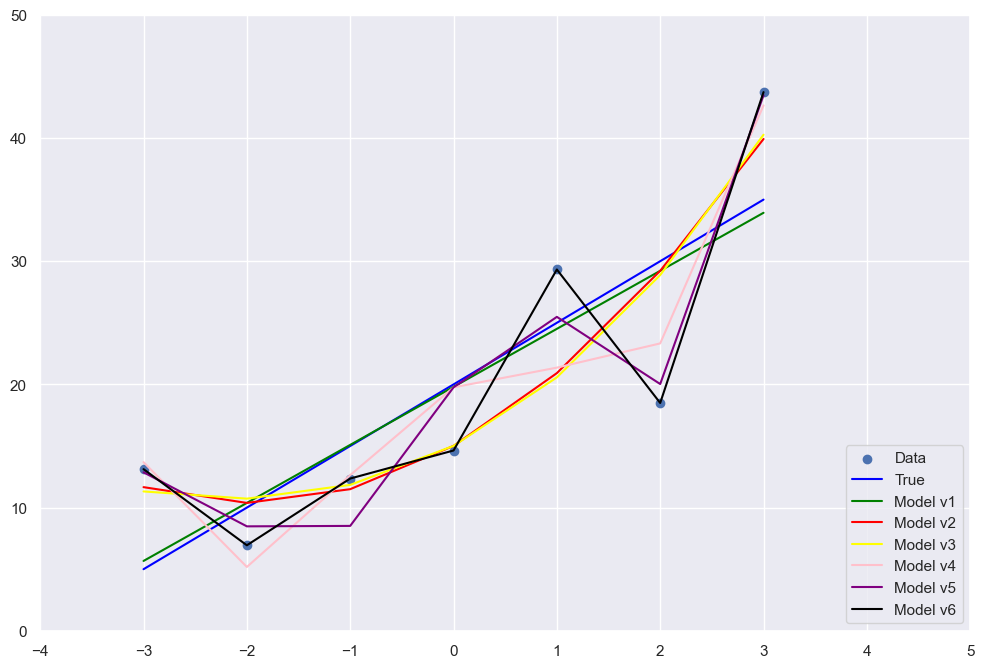

In [330]:
plt.figure(figsize=(12,8))
plt.scatter(df.x,df.y,label="Data")
plt.plot(x,q(x),color="blue",label="True")
plt.plot(x,fit_v1,color="green",label="Model v1")
plt.plot(x,fit_v2,color="red",label="Model v2")
plt.plot(x,fit_v3,color="yellow",label="Model v3")
plt.plot(x,fit_v4,color="pink",label="Model v4")
plt.plot(x,fit_v5,color="purple",label="Model v5")
plt.plot(x,fit_v6,color="black",label="Model v6")
plt.xlim([-4,5])
plt.ylim([0,50])
plt.legend(loc='lower right')
plt.show()

6次式モデルの場合、サンプルサイズとパラメータの個数が一致しているので、データに完璧にフィットするように回帰係数を選ぶことができます。もちろん、残差はゼロです。



### 問題11
OLSResultsオブジェクトのインスタンス変数を用いて
すべての多項式モデルの決定係数、修正決定係数のリストRsquared,adjRsquaredを作成します。

adjRquaredを表示しましょう。

In [331]:
#10
Rsquared=[]
adjRsquared=[]
Rsquared.append(lm_v1.rsquared)
Rsquared.append(lm_v2.rsquared)
Rsquared.append(lm_v3.rsquared)
Rsquared.append(lm_v4.rsquared)
Rsquared.append(lm_v5.rsquared)
Rsquared.append(lm_v6.rsquared)
adjRsquared.append(lm_v1.rsquared_adj)
adjRsquared.append(lm_v2.rsquared_adj)
adjRsquared.append(lm_v3.rsquared_adj)
adjRsquared.append(lm_v4.rsquared_adj)
adjRsquared.append(lm_v5.rsquared_adj)
adjRsquared.append(lm_v6.rsquared_adj)
#
print(adjRsquared)

[0.5789855757917731, 0.6627192129402599, 0.551804345178978, 0.630737085378731, 0.6193413483789887, nan]


/home/shogo/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/shogo/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


６次多項式モデルの場合、残差自由度が０となるため、修正決定係数はnanとなっています。

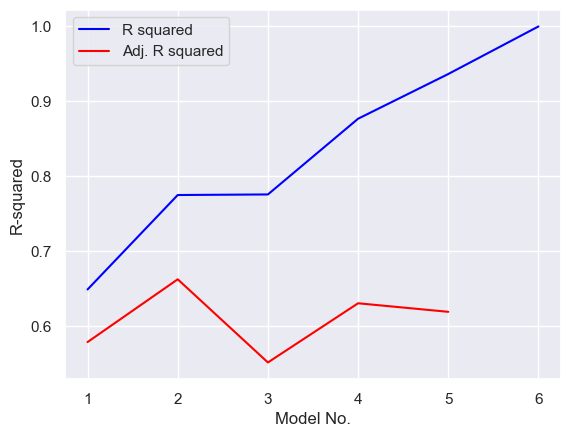

In [332]:
#決定係数を多項式の次数に対してプロット
vs=np.arange(1,7)
plt.plot(vs,Rsquared,color="blue",label="R squared")
plt.plot(vs,adjRsquared,color="red",label="Adj. R squared")
plt.legend()
plt.xlabel("Model No.")
plt.ylabel("R-squared")
plt.show()

決定係数は多項式の次数とともに増加します。

特に６次多項式モデルではデータに完全にフィットしたので、決定係数は１です。

一方、自由度を調整済みの修正決定係数は2次式モデルの場合に最大です。

修正決定係数でモデルを選択すると、2次式モデルを選ぶことになります。




MSE,RMSEも計算してみましょう。



### 問題12

すべての多項式モデルのMSEを計算し、リストMSEにインプットします。

MSEの最終成分(6次式の場合)を表示します。

In [333]:
#11 多項式モデルのMSEを計算し、リストMSEにインプット
MSE=[]
MSE.append(np.mean((df.y-lm_v1.predict())**2))
MSE.append(np.mean((df.y-lm_v2.predict())**2))
MSE.append(np.mean((df.y-lm_v3.predict())**2))
MSE.append(np.mean((df.y-lm_v4.predict())**2))
MSE.append(np.mean((df.y-lm_v5.predict())**2))
MSE.append(np.mean((df.y-lm_v6.predict())**2))
# MSEの最終成分(6次式の場合)を表示
print(MSE[5])

1.227598294045331e-25


そして、RMSEを多項式モデルの次数に対してプロットしてみます。

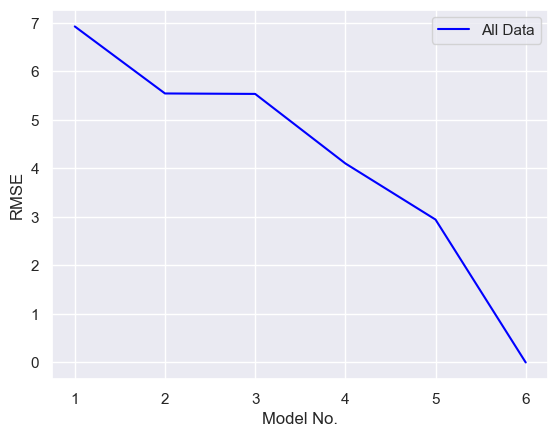

In [334]:
#RMSEを多項式の次数に対してプロット
vs=np.arange(1,7)
plt.plot(vs,np.sqrt(MSE),color="blue",label="All Data")
plt.legend()
plt.xlabel("Model No.")
plt.ylabel("RMSE")
plt.show()

１次式モデルだと平均７程度の誤差がありますが、真のモデルも１次式の標準偏差５の
ノイズを持っていたので、回帰係数の推定誤差も考えると妥当な結果です。

一方、4次式より高次のモデルでは、RMSEは5以下となり、真のモデルよりも
誤差が小さくなっています。

これは過学習の結果です。


## あてはめ誤差と汎化能力

複雑なモデルほどデータにフィットするのは当たり前です。

複雑なモデルはデータに合うようにパラメータを変更できるので当てはめ誤差(fitted Error)は小さくなります。

しかし、必要なのは未知のデータに対する予言能力です。汎化能力と呼びます。
英語の"generalization power"のほうが分かりやすいかもしれまません。


未知のデータは$q(x)$のまわりにバラツクので、予言能力を計測するには$q(x)$と
$x$に対する予測値$f(x)$の差の計算して大きさを評価します。

$$
\sum_{x}(q(x)-f(x))^2
$$


$q(x),f_{i}(x|\hat{\beta})$の差を計算してみましょう

$$
q(x)=20+5x
$$


$$
f_{1}(x|\hat{\beta})=\hat{\beta}_0+\hat{\beta}_1 x
$$


$$
f_{2}(x|\hat{\beta})=\hat{\beta}_0+\hat{\beta}_1 x+\hat{\beta}_2 x^2
$$


$$
f_{3}(x|\hat{\beta})=\hat{\beta}_0+\hat{\beta}_1 x+\hat{\beta}_2 x^2+ \hat{\beta}_3 x^3
$$


$$
f_{4}(x|\hat{\beta})=\hat{\beta}_0+\hat{\beta}_1 x+\hat{\beta}_2 x^2+ \hat{\beta}_3 x^3+\hat{\beta}_4 x^4
$$


$$
f_{5}(x|\hat{\beta})=\hat{\beta}_0+\hat{\beta}_1 x+\hat{\beta}_2 x^2+ \hat{\beta}_3 x^3+\hat{\beta}_4 x^4+\hat{\beta}_5 x^5
$$


$$
f_{6}(x|\hat{\beta})=\hat{\beta}_0+\hat{\beta}_1 x+\hat{\beta}_2 x^2+ \hat{\beta}_3 x^3+\hat{\beta}_4 x^4+\hat{\beta}_5 x^5+\hat{\beta}_6 x^6
$$




### 問題13

各次数のモデルに対して、$x=\{-3,-2,-1,0,1,2,3\}$での$f(x)$と$q(x)$の差のMSEを計算し、 リストMSE_qに代入せよ。

そして、その平方根のRMSE_qを表示せよ。

In [335]:
#𝑓(𝑥)と𝑞(𝑥)の差のMSEを計算し、 リストMSE_qに代入
MSE_q=[]
MSE_q.append(np.mean((q(df.x)-lm_v1.predict())**2))
MSE_q.append(np.mean((q(df.x)-lm_v2.predict())**2))
MSE_q.append(np.mean((q(df.x)-lm_v3.predict())**2))
MSE_q.append(np.mean((q(df.x)-lm_v4.predict())**2))
MSE_q.append(np.mean((q(df.x)-lm_v5.predict())**2))
MSE_q.append(np.mean((q(df.x)-lm_v6.predict())**2))
#平方根のRMSE_qを表示
print(np.sqrt(MSE_q))

[0.61368223 4.19503135 4.20733042 5.61325535 6.29772984 6.95222207]


In-sample(訓練データ)に対するRMSEと真のモデルに対するRMSEを多項式の次数に対してプロットします。

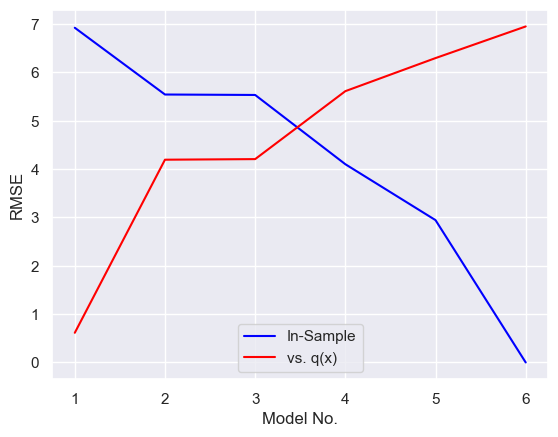

In [336]:
#RMSEを多項式の次数に対してプロット
vs=np.arange(1,7)
plt.plot(vs,np.sqrt(MSE),color="blue",label="In-Sample")
plt.plot(vs,np.sqrt(MSE_q),color="red",label="vs. q(x)")
plt.legend()
plt.xlabel("Model No.")
plt.ylabel("RMSE")
plt.show()

In-Sampleデータの場合、RMSEは６次多項式モデルで最小でした。

一方、$q(x)$に対するRMSEは１次多項式モデルで最小で、６次多項式モデルでは最大です。

つまり、In-Sampleデータにもっともフィットしたモデルは、真のモデルから
もっとも遠いモデルであることを意味します。


未知データでは、$q(x)$に標準偏差$\sigma=5$のノイズが乗っていました。

すると、独立な確率変数の和の分散は分散の和を思い出すと、未知データに
対するMSE(Oot-of-Sample)は、真のモデルに対するMSE(q(x))と$\sigma^2=25$
の和となります。
$$
\mbox{MSE(Out-of-Sample)}=\mbox{MSE(q(x))}+\sigma^2
$$

では、未知のデータに対するRMSEを多項式の次数に対して
プロットしてみます。




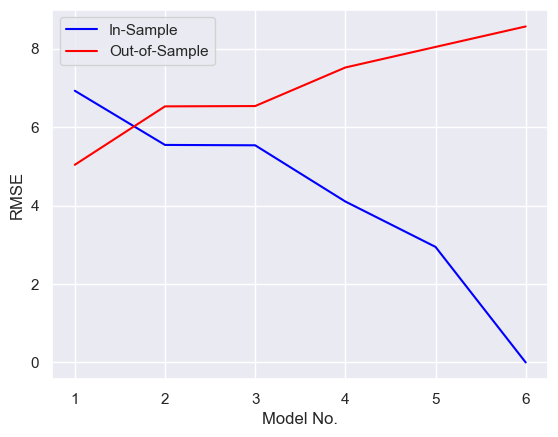

In [337]:
#RMSEを多項式の次数に対してプロット
vs=np.arange(1,7)
plt.plot(vs,np.sqrt(MSE),color="blue",label="In-Sample")
plt.plot(vs,np.sqrt(np.add(MSE_q,25)),color="red",label="Out-of-Sample")
plt.legend()
plt.xlabel("Model No.")
plt.ylabel("RMSE")
plt.show()

もちろん、定数を足しても大きさの順番に変化はないので、Out-of-SAmpleデータに対するRMSEは１次多項式モデルが最小です。

$q(x)$がわかっている場合、一次多項式モデルを選択することができます。

しかし、実際のデータ分析では、真のモデル$q(x)$は分かりません。

そのため、$q(x)$との差のMSE,RMSEを計算して、正しいモデルを選択することは出来ません。


## 未知の(Out-pf-Sample)データに対する予測誤差（MSE,RMSE）の測定


$q(x)$が分かっていないとしても、$x$に対して平均$q(x)$でデータは生成されています。

そこで、モデルのフィットに用いたデータとは別に、新たにサンプリングしてデータを
取得し、新しいデータと古いデータに対してフィットしたモデルとの差を計算することにします。

この差が小さいほど、モデルの汎化性能が高いことになります。

特に新しいデータのサンプルサイズが無限大の場合、各$x$に対する無限個のデータを
平均すると$q(x)$となるため、汎化性能を正確に評価することが出来ます。

一方、新しいデータのサンプルサイズが小さい場合、$q(x)$から大きく外れたデータを
たまたまサンプリングすることで、汎化性能を正しく評価できないことになります。

つまり、汎化性能を正確に評価し、正しいモデルを選択するには、新しい未知のデータのサンプルサイズが大きいことが必要です。



では、真のモデル$q(x)$に従う生起乱数でサンプルサイズ100のデータを生成することにします。

取得したデータをデータフレームdf_newに代入します。

データの散布図と真のモデルをプロットしてみます。

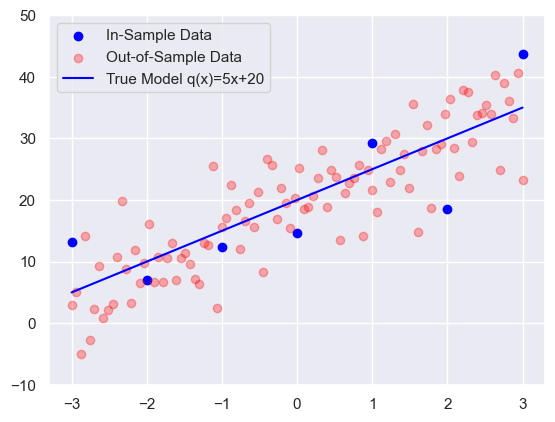

In [338]:
np.random.seed(2)
sigma=5
n=100
x=np.linspace(-3,3,n)
def q(x):
  return 20+5*x
y=stats.norm.rvs(loc=q(x),scale=sigma,size=len(q(x)))
df_new=pd.DataFrame({"x":x,"y":y})
plt.scatter(df.x,df.y,label="In-Sample Data",color="blue")
plt.scatter(df_new.x,df_new.y,label="Out-of-Sample Data",color="red",alpha=0.3)
plt.plot(x,q(x),color="blue",label="True Model q(x)=5x+20")
plt.ylim([-10,50])
plt.legend()
plt.show()

新データdf_newにxの2次、3次、4次、5次、6次の変数を追加します。



In [339]:
df_new["x2"]=df_new.x**2
df_new["x3"]=df_new.x**3
df_new["x4"]=df_new.x**4
df_new["x5"]=df_new.x**5
df_new["x6"]=df_new.x**6

### 問題14

各次数のモデルに対して、OOS(Out-of-Sample)データに対するMSEを計算し,
リストMSE_oosに代入せよ。

そして、その平方根のRMSE_oosを表示せよ。

In [340]:
#14 新データに対してMSEを計算し、リストMSE_oosに代入
MSE_oos=[]
MSE_oos.append(np.mean((df_new.y-lm_v1.predict(df_new))**2))
MSE_oos.append(np.mean((df_new.y-lm_v2.predict(df_new))**2))
MSE_oos.append(np.mean((df_new.y-lm_v3.predict(df_new))**2))
MSE_oos.append(np.mean((df_new.y-lm_v4.predict(df_new))**2))
MSE_oos.append(np.mean((df_new.y-lm_v5.predict(df_new))**2))
MSE_oos.append(np.mean((df_new.y-lm_v6.predict(df_new))**2))
#平方根のRMSE_oosを表示
print(np.sqrt(MSE_oos))

[ 5.26439514  6.35669398  6.37192243  6.50235515  7.94813082 10.31089776]


では、真のモデルで計算したRMSEと$n=10$の未知のデータで計測したRMSEをプロットしてみます。

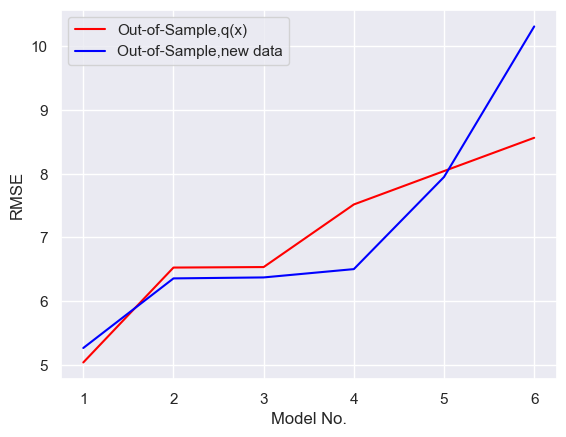

In [341]:
#RMSEを多項式の次数に対してプロット
vs=np.arange(1,7)
plt.plot(vs,np.sqrt(np.add(MSE_q,25)),color="red",label="Out-of-Sample,q(x)")
plt.plot(vs,np.sqrt(MSE_oos),color="blue",label="Out-of-Sample,new data")
plt.legend()
plt.xlabel("Model No.")
plt.ylabel("RMSE")
plt.show()

１次式の場合に最小になっていますし、値も大体一致しています。つまり、$q(x)$が分からなくても$N(q(x),\sigma^2)$から新たに
サンプリングしてMSEを計算すれば、MSEを推定することが出来ます。

また、新（未知の）データセットdf_newでモデルの予測誤差のMSEを比較すると、$f_{1}(x|\hat{\beta})$の1次式モデルが最小であることも確認できました。

## 交差検証


実際には、既存のデータでモデルをフィットし、新たにデータを取得してモデルをテスト・評価することはしません。既存のデータでモデルの推定（フィット）とテスト・評価します。

それを行うのが交差検証です。既存のデータを分割し、一部（In-SAmple Data）をモデルのフィット、一部(Out-of-Sample Data)をモデルのテストに用いる。

交差検証には単純な方法ですこし複雑な方法の2種類があります。

1. ホールドアウト法


2. k-fold 交差検証法






### ホールドアウト法

ホールドアウト法（hold-out）とは、データを学習データ（モデルのフィットに用いるデータ）と検証用のデータ（モデルの汎化能力を計測するデータ）に分割してモデル評価を行う方法です。ホールドアウト法は、モデルを推定・訓練する学習データ（df_train）と、モデルを評価するテストデータ（df_test）に分割します。そして、
df_trainで学習（フィット）したモデルの汎化能力を計算する際に、学習に使っていないデータdf_testで予測します。

ホールドアウト法は大量のデータセットがあり、モデルの推論に時間がかかる場合などに利用されます。

テストデータが大量にないと、モデルのフィットも不十分となり、テストデータでの汎化能力の推定の精度が落ちて、汎化能力の高いモデルの選択に失敗します。


訓練データとテストデータを共に大きくするには、分割前のデータが十分大きい必要があります。

一方、データのサイズが小さい場合、データの分割に仕方によってモデルの汎化能力の評価に影響が出る可能性が高いです。



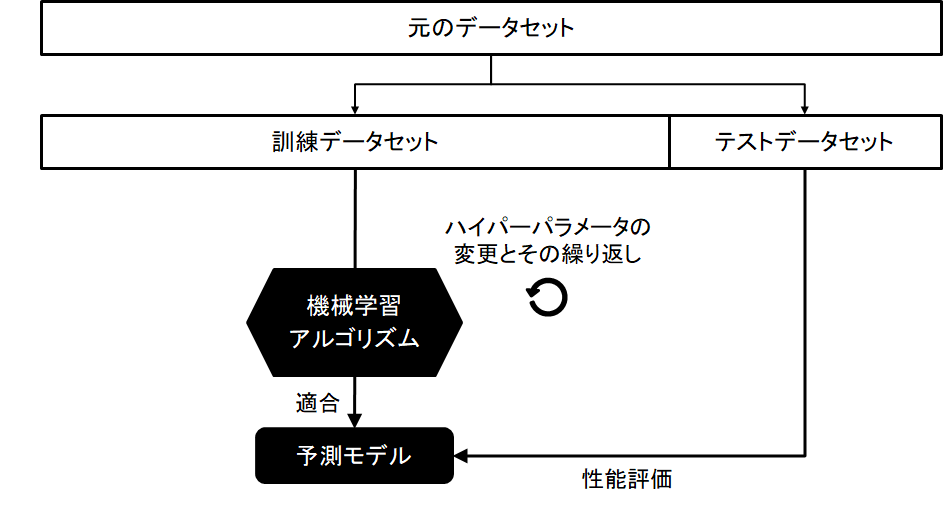


図はホールドアウト法でのモデル選択を示したものです。

データを訓練データとテストデータに分割し、訓練データでモデルをフィットし、
テストデータで汎化能力を推定します。このプロセスをさまざまなモデルで
くりかえして、汎化能力が一番高いモデルを採用します。

多項式回帰モデルの場合、多項式の次数ごとに、フィットとテストをくり返し、
テストの成績が最高の次数を選択します。


### 参考：ハイパーパラメータ

多項式モデルの次数などをハイパーパラメータと呼び、多項式モデルの回帰係数などの
通常のモデルパラメータとは区別します。


ハイパーパラメータは汎化能力が最大になるように選びます。


### ホールドアウト法でモデル選択

では、データを用意してホルドアウト法でモデル選択をやってみましょう。

$n=20$のデータを生成します。

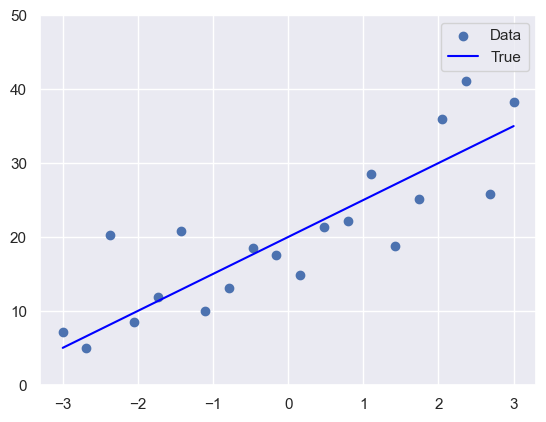

In [286]:
np.random.seed(5)
sigma=5
n=20
x=np.linspace(-3,3,n)
def q(x):
  return 20+5*x
y=stats.norm.rvs(loc=q(x),scale=sigma,size=len(q(x)))
df=pd.DataFrame({"x":x,"y":y})
plt.scatter(df.x,df.y,label="Data")
plt.plot(x,q(x),color="blue",label="True")
plt.ylim([0,50])
plt.legend()
plt.show()

多項式回帰を行うので、$x$の2次から6次の列をデータフレームdfに追加します。

In [287]:
#2,3,4,5,6次の項を説明変数に追加
df["x2"]=df.x**2
df["x3"]=df.x**3
df["x4"]=df.x**4
df["x5"]=df.x**5
df["x6"]=df.x**6
df.head()

,x,y,x2,x3,x4,x5,x6
0,-3.000000,7.206137,9.000000,-27.000000,81.000000,-243.000000,729.000000
1,-2.684211,4.924597,7.204986,-19.339700,51.911825,-139.342268,374.023983
2,-2.368421,20.311751,5.609418,-13.285464,31.465573,-74.523727,176.503563
3,-2.052632,8.476381,4.213296,-8.648345,17.751867,-36.438042,74.793875
4,-1.736842,11.863839,3.016620,-5.239393,9.099999,-15.805262,27.451244


データを訓練データとテストデータに分割します。

scikit-learnのtrain_test_split()を使うことでホールドアウト法により、データを分けることが可能です。

設定により分割する割合を変えることが出来ますが、何も設定しない場合、トレーニングデータには75%、テストデータは25%で分割されます。(test_sizeが25%にデフォルトで設定されています。)

25\%ではテストデータが少ないため、ここでは50\%で分割します。


In [288]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, random_state=1,test_size=0.5)



### 問題15

訓練データ、テストデータの行数・列数を表示せよ。



In [289]:
#15 訓練データ、テストデータの行数・列数を表示
print(df_train.shape,df_test.shape)

(10, 7) (10, 7)


$n=20$だったので、訓練データ、テストデータはは50\%で共に10行・7列になります。

訓練データとテストデータの散布図をプロットしてみます。

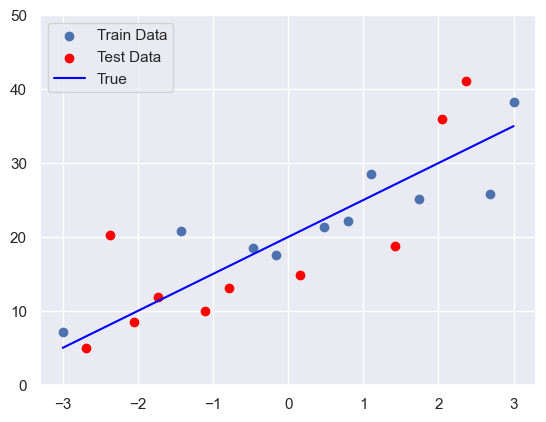

In [290]:
plt.scatter(df_train.x,df_train.y,label="Train Data")
plt.scatter(df_test.x,df_test.y,color="red",label="Test Data")
plt.plot(df.x,q(df.x),color="blue",label="True")
plt.ylim([0,50])
plt.legend()
plt.show()

では、1次式から6次式までの多項式回帰モデルを訓練データでフィットし、テストデータで汎化能力を計測してみます。



### 問題16

各次数の多項式回帰モデルに対して、訓練データのMSEを計算し、リストMSE_InSに代入せよ。そして、MSE_InSを表示せよ。




In [291]:
#16
#多項式モデルをデータにフィットせよ。
lm_vs=[]
lm_vs.append(smf.ols("y ~ x", df_train).fit())
lm_vs.append(smf.ols("y ~ x+x2", df_train).fit())
lm_vs.append(smf.ols("y ~ x+x2+x3", df_train).fit())
lm_vs.append(smf.ols("y ~ x+x2+x3+x4", df_train).fit())
lm_vs.append(smf.ols("y ~ x+x2+x3+x4+x5", df_train).fit())
lm_vs.append(smf.ols("y ~ x+x2+x3+x4+x5+x6", df_train).fit())
#訓練データのMSEの計算
MSE_InS=[]
for i in range(6):
  MSE_InS.append(np.mean((df_train.y-lm_vs[i].predict(df_train))**2))
#MSE_ISを表示
print(MSE_InS)

[12.542315258427395, 12.515117459297631, 9.658655447910785, 9.636766471256907, 2.247506887479251, 1.133446450270847]


訓練データでは６次多項式モデルがMSE最小です。



### 問題17

各次数の多項式回帰モデルに対して、テストデータでのMSEを計算し、リストMSE_OoSに代入せよ。そして、MSE_OoSを表示せよ。




In [292]:
#17
#テストデータでのMSEの計算
MSE_OoS=[]
for i in range(6):
  MSE_OoS.append(np.mean((df_test.y-lm_vs[i].predict(df_test))**2))
#MSE_ISを表示
print(MSE_OoS)

[46.99539580400451, 46.33622143894617, 58.110489073363716, 57.952100469603614, 160.33556916584993, 90.87811777567508]


テストデータでは２次多項式モデルのMSEが最小です。

訓練データ(In-Sample) と テストデータ(Out-of-Sample)でのRMSEをプロットしてみます。また、真にモデル$q(x)$に対してMSEを計算し、RMSEをプロットします。

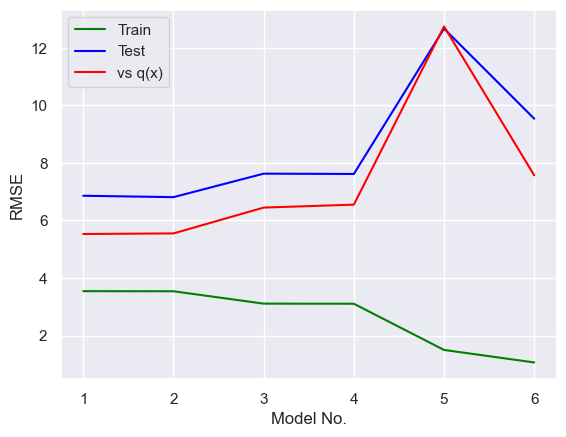

In [293]:
#q(x)でのMSEの計算
MSE_q=[]
for i in range(6):
  MSE_q.append(np.mean((q(df_test.x)-lm_vs[i].predict(df_test))**2))
plt.plot(vs,np.sqrt(MSE_InS),color="green",label="Train")
plt.plot(vs,np.sqrt(MSE_OoS),color="blue",label="Test")
plt.plot(vs,np.sqrt(np.add(MSE_q,25)),color="red",label="vs q(x)")
plt.xlabel("Model No.")
plt.ylabel("RMSE")
plt.legend()
plt.show()

真のモデルは１次多項式ですが、テストデータでMSE最小のモデルは２次多項式モデルとなりました。しかし、１次多項式モデルとの差はごくわずかです。これは、テストデータが少ないため、テストデータでの予測性能の評価に誤差が生じたためです。

実際、真のモデル$q(x)$に対するMSE,これはテストデータのサンプルサイズが無限大の
極限でもあります、を表示してみると、１次式の場合にMSEは最小です。

In [294]:
print(MSE_q)

[5.545274057007216, 5.773667800153056, 16.532891922178514, 17.856189416792922, 137.22745705074118, 32.24594667895191]



このように、ホールドアウト法では、データが少量しかない場合は正しい次数を選択できないことがあります。





次に扱う k 分割交差検証は、ホールドアウト法のデータの分割に依存しやすい点を修正した頑健な評価方法です。

### K-分割交差検証(k-fold クロスバリデーション)

交差検証の中でも、よく利用されるK-分割交差検証について説明します。
K-分割交差検証は、データをK個に分割してそのうち1つをテストデータに残りのK-1個を学習データとして正解率の評価を行います。
これをK個のデータすべてが1回ずつテストデータになるようにK回学習を行なって精度の平均をとる手法です。


k 分割交差 ･･･ 非復元抽出（重複不可）で訓練データをランダムに $k$ 個に分割する

そのうちの $k-1$ 個を訓練データ、$1$ 個を検証データとして評価を $k$ 回繰り返す


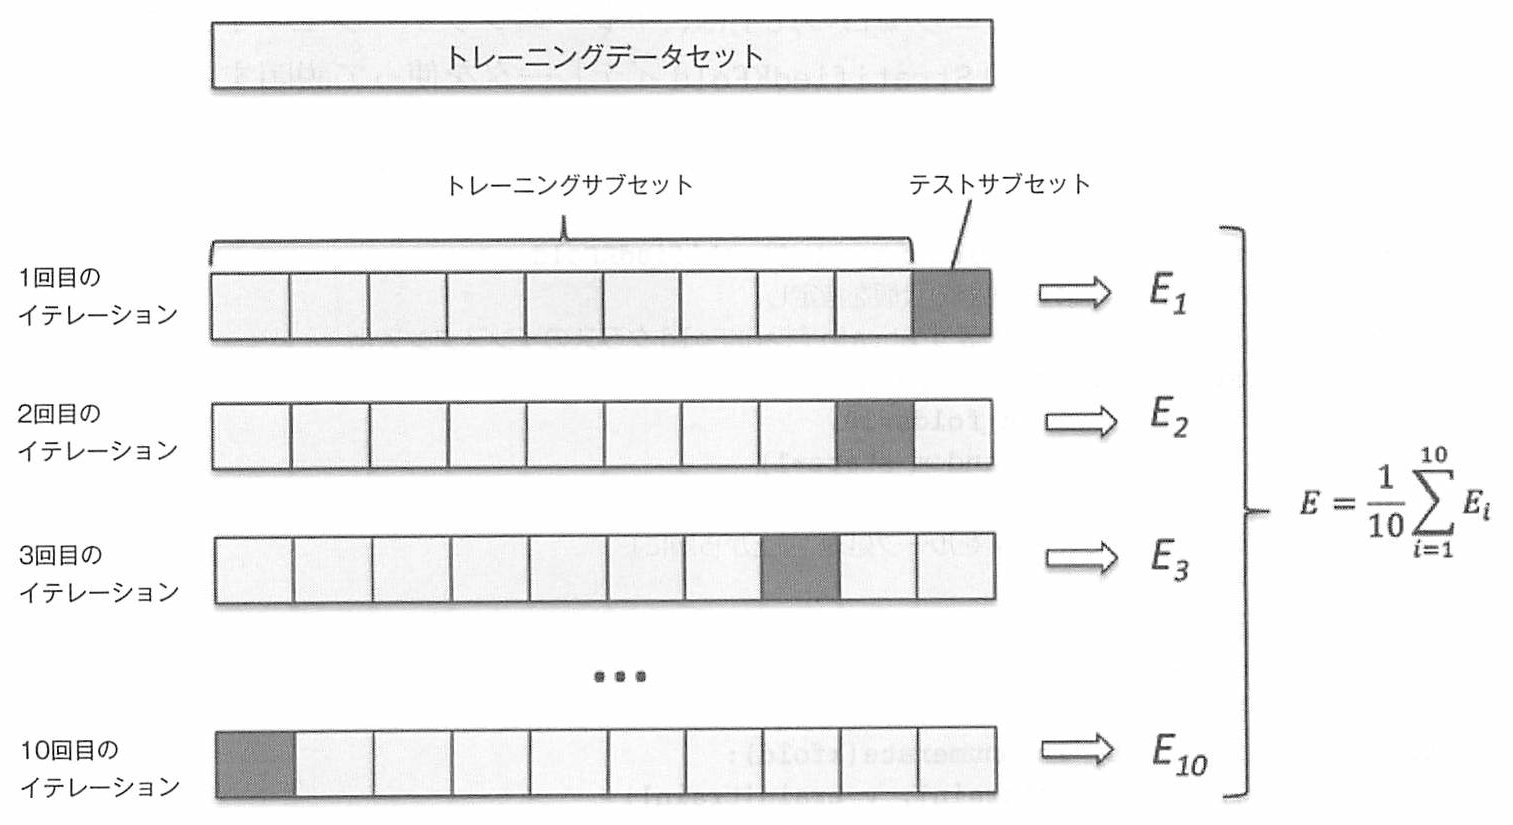



$k$ 個のモデルについて各テストサブセット（テストデータ）で評価した汎化性能の平均を真の汎化性能とします。

平均性能を計算するため、ホールドアウト法と比べて分散が小さく分割の仕方の影響を受けづらい点が長所です。

汎化性能に満足したら（満足のいくハイパーパラメータ値が見つかったら）、その設定で今度は訓練データ全体を使ってモデルを訓練します。


標準的に用いられる $k$ の値は10（バイアスとバリアンスのバランスが良いのが10）です。

https://helve-blog.com/posts/python/sklearn-cross-validation/

scikit-learnではsklearn.model_selection.KFoldというクラスにk分割交差検証が実装されています。

    sklearn.model_selection.KFold(n_splits=5, shuffle=False, random_state=None)


主なパラメータの意味は以下の通りです。

    n_splits (int): 分割するサブセットの数。デフォルト値は5（バージョン0.22より前は3）。
    shuffle (bool): Trueの場合、データをシャッフルする。デフォルト値はFalse.
    random_state (int): shuffle=Trueの場合、シャッフルするランダムシードを指定する。デフォルト値はNone（実行の度に結果が変わる）。

また、主なメソッドは以下の通りです。

    split(X): 特徴量データX（行がサンプル、列が特徴量）に対し、学習データと検証データの各インデックスを返す。


では、データフレームdfを$k=10$等分します。

$n=20$なので、訓練データは18行、テストデータは2行となります。

In [295]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [0 1]
TRAIN: [ 0  1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [2 3]
TRAIN: [ 0  1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [4 5]
TRAIN: [ 0  1  2  3  4  5  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [6 7]
TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16 17 18 19] TEST: [8 9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19] TEST: [10 11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 14 15 16 17 18 19] TEST: [12 13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16 17 18 19] TEST: [14 15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19] TEST: [16 17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18 19]


次に、各次数の多項式モデルに対して、

1.18行の訓練データでフィットし、MSEを評価（MSE_InS）

2.2行のテストデータでMSEを評価(MSE_OoS)

を10回くり返します。そして、最後にMSE_InS,MSE_OoSの平均値を
求めます。

In [296]:
#各次数の多項式モデルの10個のMSEを格納するリストを準備する。
MSE_InS_v1=[]
MSE_InS_v2=[]
MSE_InS_v3=[]
MSE_InS_v4=[]
MSE_InS_v5=[]
MSE_InS_v6=[]
MSE_OoS_v1=[]
MSE_OoS_v2=[]
MSE_OoS_v3=[]
MSE_OoS_v4=[]
MSE_OoS_v5=[]
MSE_OoS_v6=[]
for train_index, test_index in kf.split(df):
  lm_v1= smf.ols("y ~ x", df.iloc[train_index,:]).fit()
  MSE_InS_v1.append(np.mean((df.iloc[train_index,:].y-lm_v1.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v1.append(np.mean((df.iloc[test_index,:].y-lm_v1.predict(df.iloc[test_index,:]))**2))

  lm_v2= smf.ols("y ~ x+x2", df.iloc[train_index,:]).fit()
  MSE_InS_v2.append(np.mean((df.iloc[train_index,:].y-lm_v2.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v2.append(np.mean((df.iloc[test_index,:].y-lm_v2.predict(df.iloc[test_index,:]))**2))

  lm_v3= smf.ols("y ~ x+x2+x3", df.iloc[train_index,:]).fit()
  MSE_InS_v3.append(np.mean((df.iloc[train_index,:].y-lm_v3.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v3.append(np.mean((df.iloc[test_index,:].y-lm_v3.predict(df.iloc[test_index,:]))**2))

  lm_v4= smf.ols("y ~ x+x2+x3+x4", df.iloc[train_index,:]).fit()
  MSE_InS_v4.append(np.mean((df.iloc[train_index,:].y-lm_v4.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v4.append(np.mean((df.iloc[test_index,:].y-lm_v4.predict(df.iloc[test_index,:]))**2))

  lm_v5= smf.ols("y ~ x+x2+x3+x4+x5", df.iloc[train_index,:]).fit()
  MSE_InS_v5.append(np.mean((df.iloc[train_index,:].y-lm_v5.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v5.append(np.mean((df.iloc[test_index,:].y-lm_v5.predict(df.iloc[test_index,:]))**2))

  lm_v6= smf.ols("y ~ x+x2+x3+x4+x5", df.iloc[train_index,:]).fit()
  MSE_InS_v6.append(np.mean((df.iloc[train_index,:].y-lm_v6.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v6.append(np.mean((df.iloc[test_index,:].y-lm_v6.predict(df.iloc[test_index,:]))**2))
  
# 各次数の10個のMSE_InS_v*の平均値を計算し、リストMSE_InSに代入
MSE_InS=[np.mean(MSE_InS_v1),np.mean(MSE_InS_v2),np.mean(MSE_InS_v3),np.mean(MSE_InS_v4),np.mean(MSE_InS_v5),np.mean(MSE_InS_v6)]
# 各次数の10個のMSE_OoS_v*の平均値を計算し、リストMSE_OoSに代入
MSE_OoS=[np.mean(MSE_OoS_v1),np.mean(MSE_OoS_v2),np.mean(MSE_OoS_v3),np.mean(MSE_OoS_v4),np.mean(MSE_OoS_v5),np.mean(MSE_OoS_v6)]

では、訓練データとテストデータに対するRMSEをプロットしてみます。

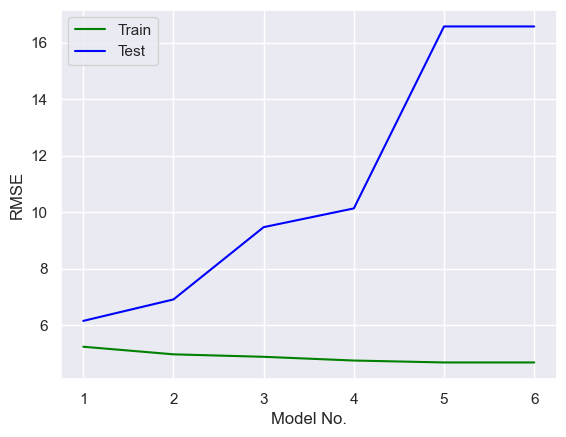

In [297]:
plt.plot(vs,np.sqrt(MSE_InS),color="green",label="Train")
plt.plot(vs,np.sqrt(MSE_OoS),color="blue",label="Test")
plt.xlabel("Model No.")
plt.ylabel("RMSE")
plt.legend()
plt.show()


テストデータに対するMSEは１次式モデルで最小です。この場合、１次式モデルを
選択することが出来ます。



## バイアスとバリアンスのトレードオフとモデル選択

では、もうすこし複雑な場合で正しいモデルを選択する練習をしてみます。

真のモデルは次の4次多項式モデルとします。

$$
q(x)=-5-10x+3x^2-x^4
$$

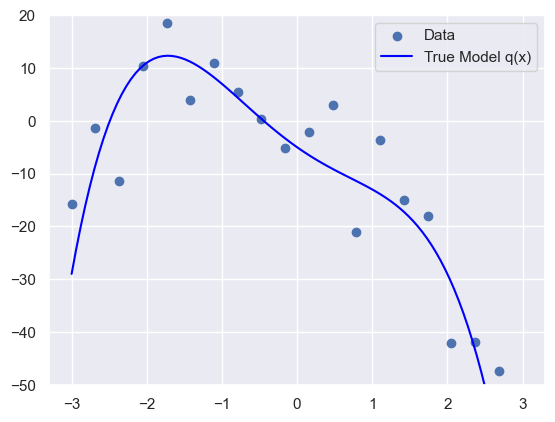

In [298]:
np.random.seed(10)
sigma=10
n=20
x=np.linspace(-3,3,n)
xs=np.linspace(-3,3,100)
def q(x):
  return -5-10*x+3*x**2-x**4
y=stats.norm.rvs(loc=q(x),scale=sigma,size=len(q(x)))
df=pd.DataFrame({"x":x,"y":y})
#2,3,4,5,6次の項を説明変数に追加
df["x2"]=df.x**2
df["x3"]=df.x**3
df["x4"]=df.x**4
df["x5"]=df.x**5
df["x6"]=df.x**6
df.head()

plt.scatter(df.x,df.y,label="Data")
plt.plot(xs,q(xs),color="blue",label="True Model q(x)")
plt.ylim([-50,20])
plt.legend()
plt.show()

データを10等分し、ひとつをテスト、残り9つの訓練データとします。

In [299]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [0 1]
TRAIN: [ 0  1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [2 3]
TRAIN: [ 0  1  2  3  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [4 5]
TRAIN: [ 0  1  2  3  4  5  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [6 7]
TRAIN: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16 17 18 19] TEST: [8 9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19] TEST: [10 11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 14 15 16 17 18 19] TEST: [12 13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16 17 18 19] TEST: [14 15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19] TEST: [16 17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18 19]




### 問題18

各次数の多項式回帰モデルに対して、訓練データ、テストデータでのMSEの平均値を計算し、リストMSE_InS,MSE_OoSに代入せよ。そして、MSE_OoSを表示せよ。




In [300]:
#各次数の多項式モデルの10個のMSEを格納するリストを準備する。
MSE_InS_v1=[]
MSE_InS_v2=[]
MSE_InS_v3=[]
MSE_InS_v4=[]
MSE_InS_v5=[]
MSE_InS_v6=[]
MSE_OoS_v1=[]
MSE_OoS_v2=[]
MSE_OoS_v3=[]
MSE_OoS_v4=[]
MSE_OoS_v5=[]
MSE_OoS_v6=[]
for train_index, test_index in kf.split(df):
  lm_v1= smf.ols("y ~ x", df.iloc[train_index,:]).fit()
  MSE_InS_v1.append(np.mean((df.iloc[train_index,:].y-lm_v1.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v1.append(np.mean((df.iloc[test_index,:].y-lm_v1.predict(df.iloc[test_index,:]))**2))

  lm_v2= smf.ols("y ~ x+x2", df.iloc[train_index,:]).fit()
  MSE_InS_v2.append(np.mean((df.iloc[train_index,:].y-lm_v2.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v2.append(np.mean((df.iloc[test_index,:].y-lm_v2.predict(df.iloc[test_index,:]))**2))

  lm_v3= smf.ols("y ~ x+x2+x3", df.iloc[train_index,:]).fit()
  MSE_InS_v3.append(np.mean((df.iloc[train_index,:].y-lm_v3.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v3.append(np.mean((df.iloc[test_index,:].y-lm_v3.predict(df.iloc[test_index,:]))**2))

  lm_v4= smf.ols("y ~ x+x2+x3+x4", df.iloc[train_index,:]).fit()
  MSE_InS_v4.append(np.mean((df.iloc[train_index,:].y-lm_v4.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v4.append(np.mean((df.iloc[test_index,:].y-lm_v4.predict(df.iloc[test_index,:]))**2))

  lm_v5= smf.ols("y ~ x+x2+x3+x4+x5", df.iloc[train_index,:]).fit()
  MSE_InS_v5.append(np.mean((df.iloc[train_index,:].y-lm_v5.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v5.append(np.mean((df.iloc[test_index,:].y-lm_v5.predict(df.iloc[test_index,:]))**2))

  lm_v6= smf.ols("y ~ x+x2+x3+x4+x5", df.iloc[train_index,:]).fit()
  MSE_InS_v6.append(np.mean((df.iloc[train_index,:].y-lm_v6.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v6.append(np.mean((df.iloc[test_index,:].y-lm_v6.predict(df.iloc[test_index,:]))**2))
  
# 各次数の10個のMSE_InS_v*の平均値を計算し、リストMSE_InSに代入
MSE_InS=[np.mean(MSE_InS_v1),np.mean(MSE_InS_v2),np.mean(MSE_InS_v3),np.mean(MSE_InS_v4),np.mean(MSE_InS_v5),np.mean(MSE_InS_v6)]
# 各次数の10個のMSE_OoS_v*の平均値を計算し、リストMSE_OoSに代入
MSE_OoS=[np.mean(MSE_OoS_v1),np.mean(MSE_OoS_v2),np.mean(MSE_OoS_v3),np.mean(MSE_OoS_v4),np.mean(MSE_OoS_v5),np.mean(MSE_OoS_v6)]
#表示
print(MSE_OoS)

[605.4252130985117, 140.33727986959937, 196.88668470851087, 236.8354952197436, 326.5541668156123, 326.5541668156123]


では、訓練データとテストデータに対するRMSEをプロットしてみます。

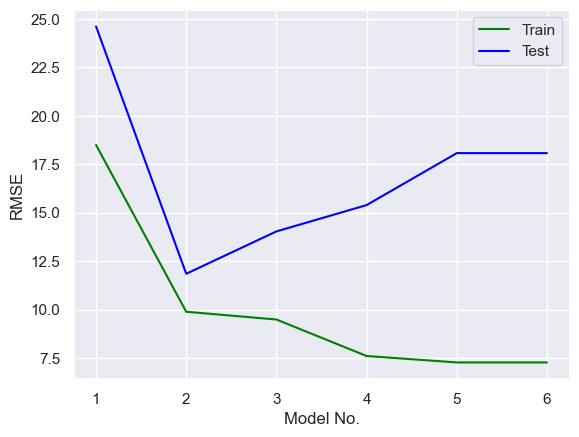

In [301]:
plt.plot(vs,np.sqrt(MSE_InS),color="green",label="Train")
plt.plot(vs,np.sqrt(MSE_OoS),color="blue",label="Test")
plt.xlabel("Model No.")
plt.ylabel("RMSE")
plt.legend()
plt.show()

$n=20$の場合、$k=10$分割の交差検証では2次式モデルの予測誤差が最小になりました。

真のモデルが複雑な場合、サンプルサイズが少ないと、バイアスとバリアンスのバランスをとって予測誤差が小さいなモデルは次数の低いモデルになります。



2次多項式モデルの回帰係数を全データでフィットして求めます。

そして、推定した2次式モデルと真のモデル、そしてデータを比較してみます。

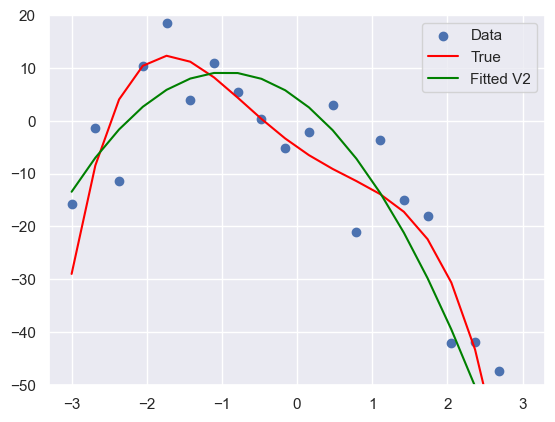

In [302]:
plt.scatter(df.x,df.y,label="Data")
plt.plot(df.x,q(df.x),color="red",label="True")
lm_v2= smf.ols("y ~ x+x2", df).fit()
plt.plot(df.x,lm_v2.predict(),color="green",label="Fitted V2")
plt.ylim([-50,20])
plt.legend()
plt.show()

サンプルサイズ$n=20$の場合、4次式モデルよりも2次式モデルのほうがデータの大まかな構造を掴んでいるように見えます。

では、サンプルサイズを増やして、$n=100$の場合に予測誤差が最小のモデルを求めてみます。

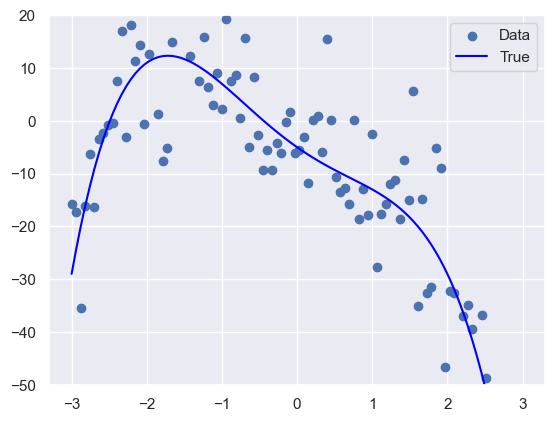

In [303]:
np.random.seed(10)
sigma=10
n=100
x=np.linspace(-3,3,n)
xs=np.linspace(-3,3,100)
def q(x):
  return -5-10*x+3*x**2-x**4
y=stats.norm.rvs(loc=q(x),scale=sigma,size=len(q(x)))
df=pd.DataFrame({"x":x,"y":y})
#2,3,4,5,6次の項を説明変数に追加
df["x2"]=df.x**2
df["x3"]=df.x**3
df["x4"]=df.x**4
df["x5"]=df.x**5
df["x6"]=df.x**6
df.head()

plt.scatter(df.x,df.y,label="Data")
plt.plot(xs,q(xs),color="blue",label="True")
plt.ylim([-50,20])
plt.legend()
plt.show()



### 問題19
データを10分割し、各次数の多項式回帰モデルに対して、訓練データ、テストデータでのMSEの平均値を計算し、リストMSE_InS,MSE_OoSに代入せよ。そして、MSE_OoSを表示せよ。




In [304]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

In [305]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
#各次数の多項式モデルの10個のMSEを格納するリストを準備する。
MSE_InS_v1=[]
MSE_InS_v2=[]
MSE_InS_v3=[]
MSE_InS_v4=[]
MSE_InS_v5=[]
MSE_InS_v6=[]
MSE_OoS_v1=[]
MSE_OoS_v2=[]
MSE_OoS_v3=[]
MSE_OoS_v4=[]
MSE_OoS_v5=[]
MSE_OoS_v6=[]
for train_index, test_index in kf.split(df):
  lm_v1= smf.ols("y ~ x", df.iloc[train_index,:]).fit()
  MSE_InS_v1.append(np.mean((df.iloc[train_index,:].y-lm_v1.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v1.append(np.mean((df.iloc[test_index,:].y-lm_v1.predict(df.iloc[test_index,:]))**2))

  lm_v2= smf.ols("y ~ x+x2", df.iloc[train_index,:]).fit()
  MSE_InS_v2.append(np.mean((df.iloc[train_index,:].y-lm_v2.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v2.append(np.mean((df.iloc[test_index,:].y-lm_v2.predict(df.iloc[test_index,:]))**2))

  lm_v3= smf.ols("y ~ x+x2+x3", df.iloc[train_index,:]).fit()
  MSE_InS_v3.append(np.mean((df.iloc[train_index,:].y-lm_v3.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v3.append(np.mean((df.iloc[test_index,:].y-lm_v3.predict(df.iloc[test_index,:]))**2))

  lm_v4= smf.ols("y ~ x+x2+x3+x4", df.iloc[train_index,:]).fit()
  MSE_InS_v4.append(np.mean((df.iloc[train_index,:].y-lm_v4.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v4.append(np.mean((df.iloc[test_index,:].y-lm_v4.predict(df.iloc[test_index,:]))**2))

  lm_v5= smf.ols("y ~ x+x2+x3+x4+x5", df.iloc[train_index,:]).fit()
  MSE_InS_v5.append(np.mean((df.iloc[train_index,:].y-lm_v5.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v5.append(np.mean((df.iloc[test_index,:].y-lm_v5.predict(df.iloc[test_index,:]))**2))

  lm_v6= smf.ols("y ~ x+x2+x3+x4+x5", df.iloc[train_index,:]).fit()
  MSE_InS_v6.append(np.mean((df.iloc[train_index,:].y-lm_v6.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v6.append(np.mean((df.iloc[test_index,:].y-lm_v6.predict(df.iloc[test_index,:]))**2))
  
# 各次数の10個のMSE_InS_v*の平均値を計算し、リストMSE_InSに代入
MSE_InS=[np.mean(MSE_InS_v1),np.mean(MSE_InS_v2),np.mean(MSE_InS_v3),np.mean(MSE_InS_v4),np.mean(MSE_InS_v5),np.mean(MSE_InS_v6)]
# 各次数の10個のMSE_OoS_v*の平均値を計算し、リストMSE_OoSに代入
MSE_OoS=[np.mean(MSE_OoS_v1),np.mean(MSE_OoS_v2),np.mean(MSE_OoS_v3),np.mean(MSE_OoS_v4),np.mean(MSE_OoS_v5),np.mean(MSE_OoS_v6)]
#表示
print(MSE_OoS)

[542.7762094090365, 186.27488645202067, 355.05948169430445, 116.68053581845587, 182.08005140066902, 182.08005140066902]


$n=100$の場合、$k=10$分割の交差検証では4次式モデルの予測誤差が最小になりました。

真のモデルが複雑でも、サンプルサイズが大きいと、バイアスとバリアンスのバランスを考慮した上でより複雑なモデルを選択します。



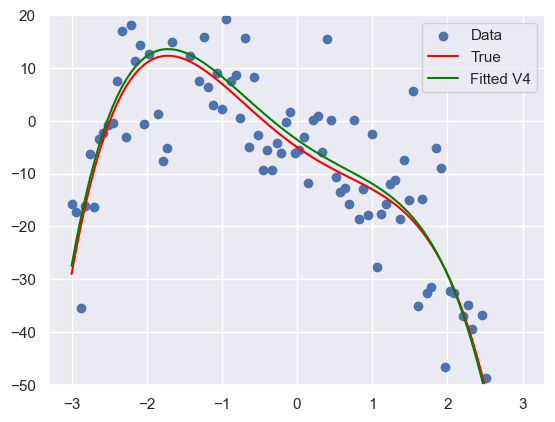

In [306]:
plt.scatter(df.x,df.y,label="Data")
plt.plot(df.x,q(df.x),color="red",label="True")
lm_v4= smf.ols("y ~ x+x2+x3+x4", df).fit()
plt.plot(df.x,lm_v4.predict(),color="green",label="Fitted V4")
plt.ylim([-50,20])
plt.legend()
plt.show()

## 補足：汎化と過学習（数式で）

- 多項式回帰のアルゴリズム
- 出力$y$が入力$x$の多項式で表されるモデル
- $d$：多項式の次数

$$
y=w_{0}+w_{1}x+w_{2}x^2+\cdots+w_{d}x^{d}+\epsilon,\mbox{V}(\epsilon)=\sigma^2 
$$

- $\epsilon$:ノイズ

- 最小二乗法で係数$\vec{w}$を決定

- $\hat{y}$:予測値

$$
\hat{y}(x,\vec{w})=w_{0}+w_{1}x+\cdots+w_{d}x^{d}
$$

$$
\hat{w}=\underset{\vec{w}}{\mbox{argmin}}||
\hat{y}(x,\vec{w})-y||^2 
$$

- 訓練データの特徴量行列$\tilde{X}$

$$
\tilde{X}=\left(\begin{array}{ccccc} 1 & x_{1} & x_{1}^2& \cdots & x_{1}^d \\
1 &x_{2} & x_{2}^2 & \cdots & x_{2}^d \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{n} & x_{n}^2 & \cdots & x_{n}^d
   \end{array}\right)
$$


- $\hat{y}(x_i,\vec{w})=y_i$

- $\hat{y}=(\hat{y}_1,\cdots,\hat{y}_{n})^{T}$

$$
\hat{y}=\left(\begin{array}{c}
w_{0}+w_{1}x_{1}+w_{2}x_{1}^2+\cdots+w_{d}x_{1}^d \\
w_{0}+w_{1}x_{2}+w_{2}x_{2}^2+\cdots+w_{d}x_{2}^d \\
\vdots \\
w_{0}+w_{1}x_{n}+w_{2}x_{n}^2+\cdots+w_{d}x_{n}^d
\end{array}
\right)
=
\left(\begin{array}{ccccc} 1 & x_{1} & x_{1}^2& \cdots & x_{1}^d \\
1 &x_{2} & x_{2}^2 & \cdots & x_{2}^d \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{n} & x_{n}^2 & \cdots & x_{n}^d
   \end{array}\right)
\left(\begin{array}{c} w_0 \\ 
w_1
\\ \vdots \\ w_d 
\end{array}\right)
=\tilde{X}\vec{w}
$$

---





### モデルの汎化性能

- $f(x)$:真の値

- $\hat{f}_{D}(x)$:データ集合$D$に対する予測値

- 平均二乗誤差

$$
\mbox{E}_{D}[(f(x)-\hat{f}_{D}(x))^2]=
\mbox{E}_{D}[(f(x)-\mbox{E}_{D}(\hat{f}_{D}(x))+
\mbox{E}_{D}(\hat{f}_{D}(x))-\hat{f}_{D}(x))^2]
$$

$$
=(f(x)-\mbox{E}_{D}[\hat{f}_{D}(x)])^2
+\mbox{E}_{D}[(\hat{f}_{D}(x)
-\mbox{E}_{D}[\hat{f}_{D}(x)])^2]
$$


- $\mbox{E}_{D}$:データ集合Dに対する平均
- 第１項：バイアス：モデルがどの程度$f(x)$を近似できるか
- 第２項：ヴァリアンス:データ集合Dの変化での予測値の変化

- 平均二乗誤差はバイアス＋ヴァリアンスなので、バイアスだけ小さくしても意味がない。

### 問題20

次の医療費データに対して20分割交差検証でモデル選択を行え。モデルは以下の６個の
モデルとする。

    model1="y ~ age + sex+ bmi+ children +smoker+region"
    model2="y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq"
    model3="y ~ age + sex+ bmi+ children +smoker+region+bmi30+age+smoker*bmi30"
    model4="y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq+smoker*bmi30+smoker*bmi"
    model5="y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq+smoker*bmi30+smoker*bmi+bmi*bmi30"
    model6="y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq+smoker*bmi30+smoker*bmi+bmi*bmi30+bmi30*age"


訓練データ、テストデータに対してMSEの平均値を計算し、MSE_InS,MSE_OoSに代入せよ。

そして、MSE_OoSが最小となるモデルをモデルの番号とRMSEを答えよ。RMSEは少数１位を
四捨五入して整数値で回答すること。


In [307]:
#19
Model_No=4
print(Model_No)
RMSE=np.sqrt(MSE_OoS[3])
print(RMSE)

4
10.801876495241736


In [308]:
#WEB上のcsvデータを読み込んでデータフレームとする。
import pandas as pd
import urllib.request
from io import StringIO
#WEB上のデータのURLを指定
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
#データを読み込む関数を定義
def read_csv(url):
    print(url)
    res = urllib.request.urlopen(url)
    res = res.read().decode("utf-8")
    df = pd.read_csv(StringIO(res))
    return df
df=read_csv(url)
df= df.astype({"sex":"category","smoker":"category","region":"category"})
df.rename(columns={"charges":"y"},inplace=True) # 目的変数の名前をchargesからyに変更
df["bmi30"]=df["bmi"]>30
df["age_sq"]=df["age"]**2
df.info()

https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   y         1338 non-null   float64 
 7   bmi30     1338 non-null   bool    
 8   age_sq    1338 non-null   int64   
dtypes: bool(1), category(3), float64(2), int64(3)
memory usage: 58.1 KB


In [309]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

model1="y ~ age + sex+ bmi+ children +smoker+region"
model2="y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq"
model3="y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq+smoker*bmi30"
model4="y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq+smoker*bmi30+smoker*bmi"
model5="y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq+smoker*bmi30+smoker*bmi+bmi*bmi30"
model6="y ~ age + sex+ bmi+ children +smoker+region+bmi30+age_sq+smoker*bmi30+smoker*bmi+bmi*bmi30+bmi30*age"

In [310]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
#各次数の多項式モデルの10個のMSEを格納するリストを準備する。
MSE_InS_v1=[]
MSE_InS_v2=[]
MSE_InS_v3=[]
MSE_InS_v4=[]
MSE_InS_v5=[]
MSE_InS_v6=[]
MSE_OoS_v1=[]
MSE_OoS_v2=[]
MSE_OoS_v3=[]
MSE_OoS_v4=[]
MSE_OoS_v5=[]
MSE_OoS_v6=[]
for train_index, test_index in kf.split(df):
  lm_v1= smf.ols(model1, df.iloc[train_index,:]).fit()
  MSE_InS_v1.append(np.mean((df.iloc[train_index,:].y-lm_v1.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v1.append(np.mean((df.iloc[test_index,:].y-lm_v1.predict(df.iloc[test_index,:]))**2))

  lm_v2= smf.ols(model2, df.iloc[train_index,:]).fit()
  MSE_InS_v2.append(np.mean((df.iloc[train_index,:].y-lm_v2.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v2.append(np.mean((df.iloc[test_index,:].y-lm_v2.predict(df.iloc[test_index,:]))**2))

  lm_v3= smf.ols(model3, df.iloc[train_index,:]).fit()
  MSE_InS_v3.append(np.mean((df.iloc[train_index,:].y-lm_v3.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v3.append(np.mean((df.iloc[test_index,:].y-lm_v3.predict(df.iloc[test_index,:]))**2))

  lm_v4= smf.ols(model4, df.iloc[train_index,:]).fit()
  MSE_InS_v4.append(np.mean((df.iloc[train_index,:].y-lm_v4.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v4.append(np.mean((df.iloc[test_index,:].y-lm_v4.predict(df.iloc[test_index,:]))**2))

  lm_v5= smf.ols(model5, df.iloc[train_index,:]).fit()
  MSE_InS_v5.append(np.mean((df.iloc[train_index,:].y-lm_v5.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v5.append(np.mean((df.iloc[test_index,:].y-lm_v5.predict(df.iloc[test_index,:]))**2))

  lm_v6= smf.ols(model6, df.iloc[train_index,:]).fit()
  MSE_InS_v6.append(np.mean((df.iloc[train_index,:].y-lm_v6.predict(df.iloc[train_index,:]))**2))
  MSE_OoS_v6.append(np.mean((df.iloc[test_index,:].y-lm_v6.predict(df.iloc[test_index,:]))**2))
  
# 各次数の10個のMSE_InS_v*の平均値を計算し、リストMSE_InSに代入
MSE_InS=[np.mean(MSE_InS_v1),np.mean(MSE_InS_v2),np.mean(MSE_InS_v3),np.mean(MSE_InS_v4),np.mean(MSE_InS_v5),np.mean(MSE_InS_v6)]
# 各次数の10個のMSE_OoS_v*の平均値を計算し、リストMSE_OoSに代入
MSE_OoS=[np.mean(MSE_OoS_v1),np.mean(MSE_OoS_v2),np.mean(MSE_OoS_v3),np.mean(MSE_OoS_v4),np.mean(MSE_OoS_v5),np.mean(MSE_OoS_v6)]
#表示
print(MSE_OoS)

[36990225.366877094, 35969372.2488121, 19711083.365399294, 19234646.39914777, 19261039.86402944, 19310582.695241652]


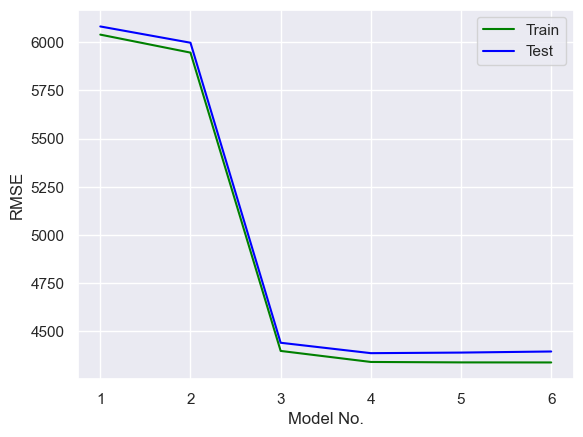

In [311]:
plt.plot(vs,np.sqrt(MSE_InS),color="green",label="Train")
plt.plot(vs,np.sqrt(MSE_OoS),color="blue",label="Test")
plt.xlabel("Model No.")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [312]:
np.sqrt(MSE_OoS[3])

4385.732139466314